<a href="https://colab.research.google.com/github/codrae/timeseries-dl-models/blob/main/AMPds2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import matplotlib.pyplot as plt
import os
import random

In [74]:
# 시드 값 고정
seed = 42

# Python 내장 해시 함수의 시드를 고정하여 재현성을 확보 (Python 3.3 이상에서만 적용)
os.environ['PYTHONHASHSEED'] = str(seed)

random.seed(seed) # Python의 random 모듈
np.random.seed(seed )# NumPy의 난수 생성기
torch.manual_seed(seed) # PyTorch의 난수 생성기

torch.cuda.manual_seed(seed) #GPU의 난수 생성기
torch.backends.cudnn.deterministic = True # CuDNN을 사용할 때, 비결정론적 알고리즘을 사용하지 않도록 설정
torch.backends.cudnn.benchmark = False # CuDNN의 벤치마크 기능을 비활성화하여 매번 동일한 연산 경로가 사용되도록 설정

# GPU가 사용 가능하면 CUDA 장치로 설정, 그렇지 않으면 CPU로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 설정된 장치(device) 출력
device

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Electricity_B2E_processed.csv')
df.set_index('date', inplace=True)
df.head()

,P
date,
2012-04-01 07:00:00,9.516667
2012-04-01 08:00:00,7.466667
2012-04-01 09:00:00,7.316667
2012-04-01 10:00:00,7.416667
2012-04-01 11:00:00,7.500000


In [76]:
# 데이터 로드 및 전처리 (데이터셋 나누기 전에 수행하는 것이 좋음!)
def load_data_from_csv(df, column_name):
    data = df
    data = data[column_name].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler

data, scaler = load_data_from_csv(df, 'P')

In [77]:
# 데이터셋 클래스 정의
class B2EDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size]
        y = self.data[idx+self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [78]:
# 데이터셋 생성
window_size = 24
dataset = B2EDataset(data, window_size)

# 훈련/검증 데이터 분리 (80% 훈련 데이터, 20% 테스트 데이터)
train_size = int(len(dataset) * 0.80)

# 학습과 테스트 데이터셋을 슬라이싱으로 나누기
train_dataset = Subset(dataset, list(range(train_size)))
test_dataset = Subset(dataset, list(range(train_size, len(dataset))))

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [79]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2): # LSTM 전체 모델 정의
        super(LSTMModel, self).__init__() # Moudle(부모 클래스의 생성자 호출
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # nn.LSTM을 통해 LSTM 레이어 정의
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # 출력 크기 조정 (FC레이어 = 선형 변환 레이어 정의)
        self.fc = nn.Linear(hidden_size, output_size)

        # 가중치와 편향을 초기화
        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x): # x는 입력 데이터 (하나의 batch)
        # 초기 은닉 상태와 셀 상태 정의
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 통과
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시퀀스의 출력만 선택하여 FC 레이어에 통과
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)  # 시그모이드 활성화 함수 추가

        return out

In [80]:
# 모델 학습 함수
def train_model(train_loader, num_epochs=100, learning_rate=0.001, device=device):
    model = LSTMModel().to(device)
    criterion = nn.MSELoss() #손실 함수
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #최적 가중치를 찾아주는 알고리즘

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for seqs, targets in train_loader:
            seqs, targets = seqs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if (epoch + 1) % 10 == 0:
          avg_loss = epoch_loss / len(train_loader)
          print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')



    return model

In [81]:
# 모델 학습
model = train_model(train_loader, device=device)

Epoch 10/100, Average Loss: 0.0154
Epoch 20/100, Average Loss: 0.0145
Epoch 30/100, Average Loss: 0.0134
Epoch 40/100, Average Loss: 0.0119
Epoch 50/100, Average Loss: 0.0119
Epoch 60/100, Average Loss: 0.0114
Epoch 70/100, Average Loss: 0.0141
Epoch 80/100, Average Loss: 0.0135
Epoch 90/100, Average Loss: 0.0147
Epoch 100/100, Average Loss: 0.0143


In [82]:
# 예측 함수
def predict(model, test_loader, scaler, device=device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for seqs, targets in test_loader:
            seqs, targets = seqs.to(device), targets.to(device)
            outputs = model(seqs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    return predictions, actuals

Index converted to DatetimeIndex.


<ipython-input-83-030c038af7e3>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df_daily = train_df.resample('D').mean().fillna(method='ffill')
<ipython-input-83-030c038af7e3>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df_daily = test_df.resample('D').mean().fillna(method='ffill')
<ipython-input-83-030c038af7e3>:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_actuals_daily = test_actuals_df.resample('D').mean().fillna(method='ffill')
<ipython-input-83-030c038af7e3>:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_predictions_daily = test_predictions_df.resample('D').mean().fillna(method='ffil

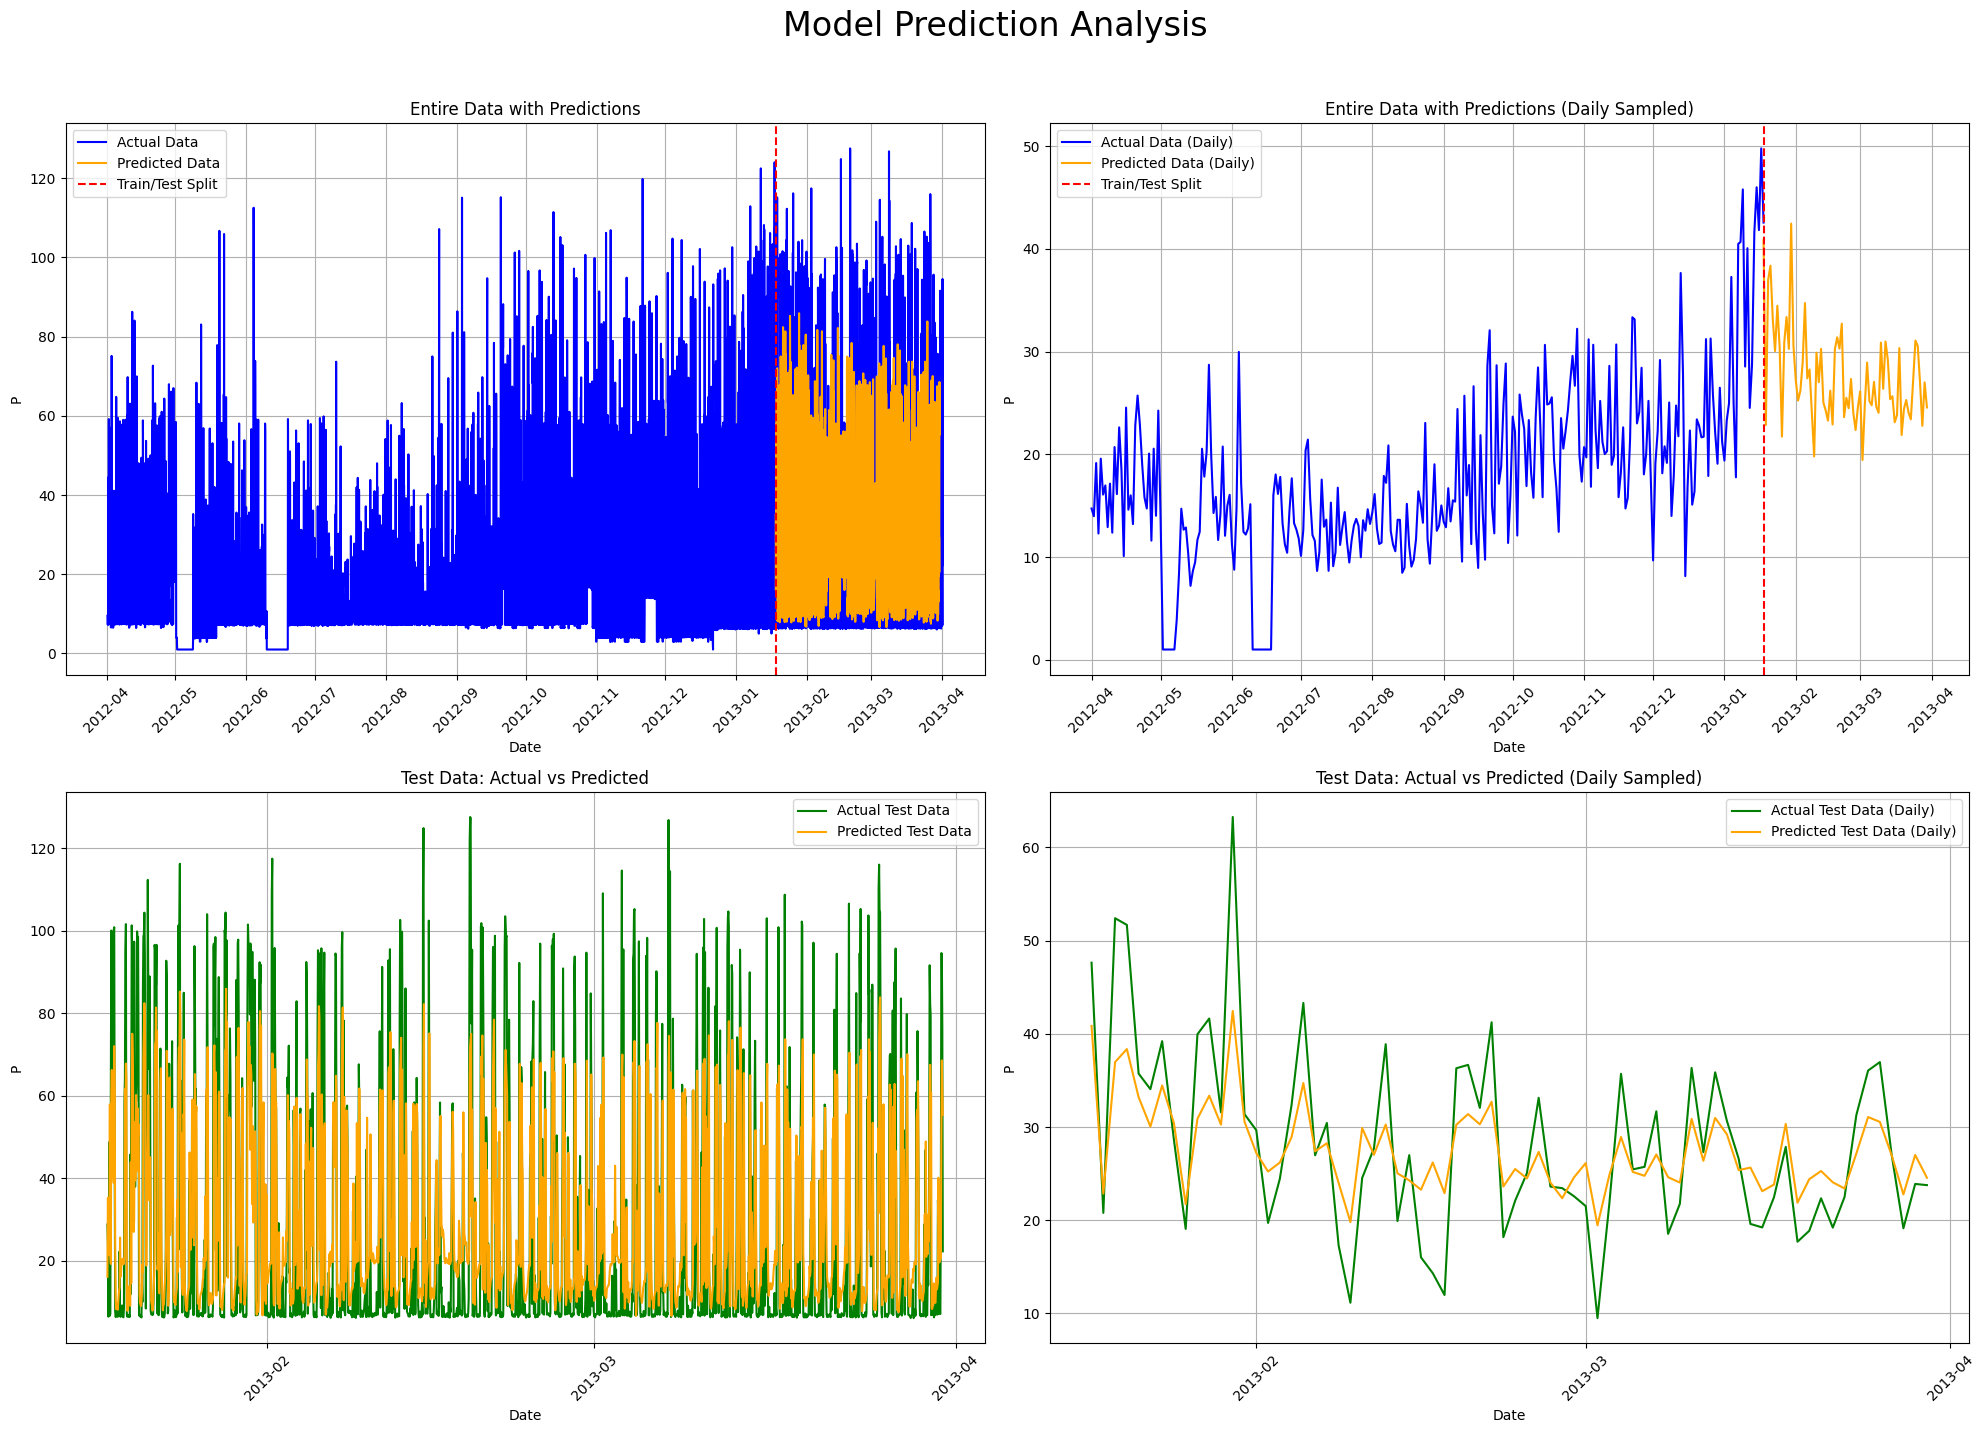

In [83]:
# 1. Ensure the DataFrame index is a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)
    print("Index converted to DatetimeIndex.")

# 2. Ensure the index is sorted
if not df.index.is_monotonic_increasing:
    df = df.sort_index()
    print("Index sorted in ascending order.")

# 3. Split the dataset into training and testing (80% train, 20% test)
total_length = len(df)
split_point = int(0.8 * total_length)

train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:]

# 4. Generate Predictions and Actuals
predictions, actuals = predict(model, test_loader, scaler, device=device)

# 5. Create DataFrames for Actual and Predicted values
# Adjust the index to match the length of predictions and actuals
# Assuming predictions and actuals correspond to the test_df
test_actuals_df = pd.DataFrame(actuals, index=test_df.index[:len(actuals)], columns=['Actual'])
test_predictions_df = pd.DataFrame(predictions, index=test_df.index[:len(predictions)], columns=['Predicted'])

# 6. Resample to Daily Frequency
# If data is already daily, resampling might just retain the data
train_df_daily = train_df.resample('D').mean().fillna(method='ffill')
test_df_daily = test_df.resample('D').mean().fillna(method='ffill')
test_actuals_daily = test_actuals_df.resample('D').mean().fillna(method='ffill')
test_predictions_daily = test_predictions_df.resample('D').mean().fillna(method='ffill')

# 7. Plotting
fig, axs = plt.subplots(2, 2, figsize=(20, 14), constrained_layout=True)

# Function to format x-axis
def format_xaxis(ax):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

# Determine the split date for vertical line
split_date = train_df.index[-1]

# ------------------- Graph 1 -------------------
ax1 = axs[0, 0]
ax1.plot(df.index, df['P'], label='Actual Data', color='blue')
ax1.plot(test_predictions_df.index, test_predictions_df['Predicted'], label='Predicted Data', color='orange')
ax1.axvline(x=split_date, color='red', linestyle='--', label='Train/Test Split')
format_xaxis(ax1)
ax1.set_title('Entire Data with Predictions')
ax1.set_xlabel('Date')
ax1.set_ylabel('P')
ax1.legend()
ax1.grid(True)

# ------------------- Graph 2 -------------------
ax2 = axs[0, 1]
ax2.plot(train_df_daily.index, train_df_daily['P'], label='Actual Data (Daily)', color='blue')
ax2.plot(test_predictions_daily.index, test_predictions_daily['Predicted'], label='Predicted Data (Daily)', color='orange')
ax2.axvline(x=split_date, color='red', linestyle='--', label='Train/Test Split')
format_xaxis(ax2)
ax2.set_title('Entire Data with Predictions (Daily Sampled)')
ax2.set_xlabel('Date')
ax2.set_ylabel('P')
ax2.legend()
ax2.grid(True)

# ------------------- Graph 3 -------------------
ax3 = axs[1, 0]
ax3.plot(test_actuals_df.index, test_actuals_df['Actual'], label='Actual Test Data', color='green')
ax3.plot(test_predictions_df.index, test_predictions_df['Predicted'], label='Predicted Test Data', color='orange')
format_xaxis(ax3)
ax3.set_title('Test Data: Actual vs Predicted')
ax3.set_xlabel('Date')
ax3.set_ylabel('P')
ax3.legend()
ax3.grid(True)

# ------------------- Graph 4 -------------------
ax4 = axs[1, 1]
ax4.plot(test_actuals_daily.index, test_actuals_daily['Actual'], label='Actual Test Data (Daily)', color='green')
ax4.plot(test_predictions_daily.index, test_predictions_daily['Predicted'], label='Predicted Test Data (Daily)', color='orange')
format_xaxis(ax4)
ax4.set_title('Test Data: Actual vs Predicted (Daily Sampled)')
ax4.set_xlabel('Date')
ax4.set_ylabel('P')
ax4.legend()
ax4.grid(True)

# Overall Title
plt.suptitle('Model Prediction Analysis', fontsize=24, y=1.02)

# Adjust layout to make space for the suptitle
plt.tight_layout()

# Display the plots
plt.show()


In [84]:
mae = mean_absolute_error(test_actuals_df['Actual'], test_predictions_df['Predicted'])
rmse = np.sqrt(mean_squared_error(test_actuals_df['Actual'], test_predictions_df['Predicted']))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 16.5549
RMSE: 23.5631
